## 3.8 多层感知机
我们已经介绍了包括线性回归和softmax回归在内的单层神经网络。然而深度学习主要关注多层模型。在本节中，我们将以多层感知机（multilayer perceptron，MLP）为例，介绍多层神经网络的概念。

### 3.8.2 激活函数
上述问题的根源在于全连接层只是对数据做仿射变换（affine transformation），而多个仿射变换的叠加仍然是一个仿射变换。解决问题的一个方法是引入非线性变换，例如对隐藏变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数被称为激活函数（activation function）。下面我们介绍几个常用的激活函数。

#### 3.8.2.1 ReLU函数
ReLU（rectified linear unit）函数提供了一个很简单的非线性变换。给定元素xx，该函数定义为

ReLU(x)=max(x,0).ReLU(x)=max(x,0).
可以看出，ReLU函数只保留正数元素，并将负数元素清零。为了直观地观察这一非线性变换，我们先定义一个绘图函数xyplot。

In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
def use_svg_display():
    # 用矢量图显示
    %config InlineBackend.figure_format = 'svg'

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def xyplot(x_vals, y_vals, name):
    # 设置图形大小为5x2.5
    set_figsize(figsize=(5, 2.5))
    # 绘制x_vals和y_vals的曲线
    plt.plot(x_vals.numpy(), y_vals.numpy())
    # 设置x轴标签
    plt.xlabel('x')
    # 设置y轴标签为函数名+' (x)'
    plt.ylabel(name + '(x)')

我们接下来通过Tensor提供的relu函数来绘制ReLU函数。可以看到，该激活函数是一个两段线性函数。

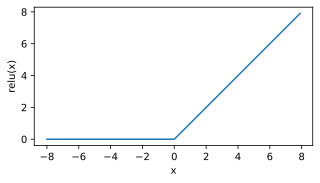

In [4]:
# 创建一个从-8到8的等间隔序列，间隔为0.1，数据类型为float32
x = tf.Variable(tf.range(-8,8,0.1),dtype=tf.float32)

# 对x应用ReLU激活函数
y = tf.nn.relu(x)

# 绘制ReLU函数的图像
xyplot(x, y, 'relu')

显然，当输入为负数时，ReLU函数的导数为0；当输入为正数时，ReLU函数的导数为1。尽管输入为0时ReLU函数不可导，但是我们可以取此处的导数为0。下面绘制ReLU函数的导数。

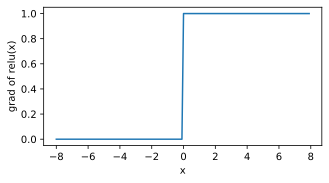

In [6]:
# 使用GradientTape来计算ReLU函数的梯度
# GradientTape是TensorFlow用于自动微分的工具, 会记录上下文中的所有操作
with tf.GradientTape() as t:
    # 监视x变量以便计算其梯度
    t.watch(x)
    
    # 计算ReLU函数
    # ReLU函数定义为f(x) = max(0, x)
    y = tf.nn.relu(x)

# 计算y相对于x的梯度
# 这里实际上是在计算ReLU函数的导数
# ReLU函数的导数特点:
# - 当x > 0时,导数为1
# - 当x < 0时,导数为0
# - 在x = 0处,导数理论上不存在, 但在实践中通常定义为0或0.5
dy_dx = t.gradient(y, x)

# 绘制ReLU函数梯度的图像
# 这将显示一个阶跃函数:在x轴负半部分为0,正半部分为1,在x=0处可能有一个不连续点
# 这种可视化有助于理解ReLU函数在神经网络中的行为,特别是在反向传播过程中梯度如何流动
xyplot(x, dy_dx, 'grad of relu')

#### 3.8.2.2 sigmoid函数
sigmoid函数可以将元素的值变换到0和1之间：

$sigmoid(x) = \frac{1}{1 + \exp(-x)}$

sigmoid函数在早期的神经网络中较为普遍，但它目前逐渐被更简单的ReLU函数取代。在后面“循环神经网络”一章中我们会介绍如何利用它值域在0到1之间这一特性来控制信息在神经网络中的流动。下面绘制了sigmoid函数。当输入接近0时，sigmoid函数接近线性变换。

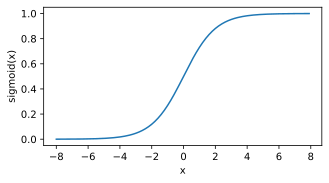

In [7]:
y = tf.nn.sigmoid(x)
xyplot(x, y, 'sigmoid')

据链式法则，sigmoid函数的导数

$\frac{d}{dx}\text{sigmoid}(x) = \frac{\exp(-x)}{(1+\exp(-x))^2} = \text{sigmoid}(x)(1-\text{sigmoid}(x))$

下面绘制了sigmoid函数的导数。当输入为0时，sigmoid函数的导数达到最大值0.25；当输入越偏离0时，sigmoid函数的导数越接近0。

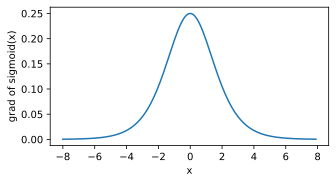

In [9]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.sigmoid(x)
dy_dx = t.gradient(y, x)
xyplot(x, dy_dx, 'grad of sigmoid')

#### 3.8.2.3 tanh函数
tanh（双曲正切）函数可以将元素的值变换到-1和1之间：
 .
我们接着绘制tanh函数。当输入接近0时，tanh函数接近线性变换。虽然该函数的形状和sigmoid函数的形状很像，但tanh函数在坐标系的原点上对称。

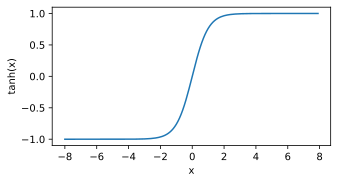

In [10]:
y = tf.nn.tanh(x)
xyplot(x, y, 'tanh')

依据链式法则，tanh函数的导数

$\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)$
 
下面绘制了tanh函数的导数。当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数越接近0。

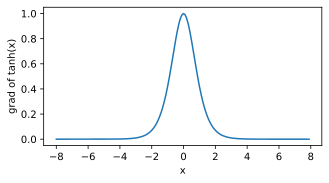

In [11]:
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.nn.tanh(x)
dy_dx = t.gradient(y, x)
xyplot(x, dy_dx, 'grad of tanh')

### 3.8.3 多层感知机
多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。以单隐藏层为例并沿用本节之前定义的符号，多层感知机按以下方式计算输出：

$H=ϕ(XWh+bh), O=HWo+bo,$
其中ϕ表示激活函数。在分类问题中，我们可以对输出O做softmax运算，并使用softmax回归中的交叉熵损失函数。 在回归问题中，我们将输出层的输出个数设为1，并将输出O直接提供给线性回归中使用的平方损失函数。

小结
多层感知机在输出层与输入层之间加入了一个或多个全连接隐藏层，并通过激活函数对隐藏层输出进行变换。
常用的激活函数包括ReLU函数、sigmoid函数和tanh函数。